In [1]:
import pandas as pd


In [2]:
import csv

In [3]:
data = pd.read_csv('labeled_data.csv', encoding = "ISO-8859-1", low_memory=False)
data.head(5)

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


In [4]:
data.shape

(24783, 7)

In [5]:

tweet = data["tweet"][9].replace("\n", " ")
print(tweet)

" @rhythmixx_ :hobbies include: fighting Mariam"  bitch


In [6]:
#Make 90% of data for training
#Original dataset said 0=Hate speech, 1=Offensive but not hate speech, 2=neither 
#We need binary labels so first we made +1 only if it is not hate speech (>0) but this made majority of the dataset +1 and very few -1. 
#So, changed labels so only classified as non-hate if orig label (>1)
training = open("training_data.txt", "w+")
for i in range(int(0.9*data.shape[0])):
  tweet = data["tweet"][i].replace("\n", " ")
  label = data["class"][i]
  if label > 1:
    label = "+1"
  else:
    label = "-1"
  
  training.write(label + " " + tweet + "\n")

training.close()

In [7]:
validation = open("validation_data.txt", "w+")
for i in range(1239):
  tweet = data["tweet"][22304+i].replace("\n", " ")

  label = data["class"][22304+i]
  if label > 1:
    label = "+1"
  else:
    label = "-1"
  
  validation.write(label + " " + tweet + "\n")

validation.close()

In [8]:
testing = open("testing_data.txt", "w+")
for i in range(1240):
  tweet = data["tweet"][23543+i].replace("\n", " ")

  label = data["class"][23543+i]
  if label > 1:
    label = "+1"
  else:
    label = "-1"
  
  testing.write(label + " " + tweet + "\n")

testing.close()

In [9]:
from typing import Callable, Dict, List, Tuple, TypeVar

In [10]:
import random
import sys
from collections import Counter

In [11]:
def dotProduct(d1, d2):
  
    if len(d1) < len(d2):
        return dotProduct(d2, d1)
    else:
        return sum(d1.get(f, 0) * v for f, v in list(d2.items()))


def increment(d1, scale, d2):
  
    for f, v in list(d2.items()):
        d1[f] = d1.get(f, 0) + v * scale


def readExamples(path):
 
    examples = []
    for line in open(path, "rb"):
        
        line = line.decode('latin-1')
      
        y, x = line.split(' ', 1)
        examples.append((x.strip(), int(y)))
    print('Read %d examples from %s' % (len(examples), path))
    return examples


def evaluatePredictor(examples, predictor):
   
    error = 0
    for x, y in examples:
        if predictor(x) != y:
            error += 1
    return 1.0 * error / len(examples)


def outputWeights(weights, path):
    print("%d weights" % len(weights))
    out = open(path, 'w', encoding='utf8')
    for f, v in sorted(list(weights.items()), key=lambda f_v: -f_v[1]):
        print('\t'.join([f, str(v)]), file=out)
    out.close()


def verbosePredict(phi, y, weights, out):
    yy = 1 if dotProduct(phi, weights) >= 0 else -1
    if y:
        print('Truth: %s, Prediction: %s [%s]' % (
            y, yy, 'CORRECT' if y == yy else 'WRONG'), file=out)
    else:
        print('Prediction:', yy, file=out)
    for f, v in sorted(list(phi.items()), key=lambda f_v1: -f_v1[1] * weights.get(f_v1[0], 0)):
        w = weights.get(f, 0)
        print("%-30s%s * %s = %s" % (f, v, w, v * w), file=out)
    return yy


def outputErrorAnalysis(examples, featureExtractor, weights, path):
    out = open(path, 'w')
    for x, y in examples:
        print('===', x, file=out)
        verbosePredict(featureExtractor(x), y, weights, out)
    out.close()


def interactivePrompt(featureExtractor, weights):
    while True:
        print('> ', end=' ')
        x = sys.stdin.readline()
        if not x:
            break
        phi = featureExtractor(x)
        verbosePredict(phi, None, weights, sys.stdout)


In [12]:
FeatureVector = Dict[str, int]
WeightVector = Dict[str, float]
Example = Tuple[FeatureVector, int]

In [13]:
def extractWordFeatures(x: str) -> FeatureVector:

    d = {}
    for word in x.split():
        if word not in d:
            d[word] = 1
        else:
            d[word] += 1

    return d

In [14]:
T = TypeVar('T')

import matplotlib.pyplot as plt

def learnPredictor(trainExamples: List[Tuple[T, int]],
                   validationExamples: List[Tuple[T, int]],
                   featureExtractor: Callable[[T], FeatureVector],
                   numEpochs: int, eta: float) -> WeightVector:
   
    weights = {}  # feature => weight

    trainingLosses = []
    validationLosses = []
    for i in range(numEpochs):
        for example in trainExamples:
            
            feature_value = featureExtractor(example[0]) #Gives dict of features
            score = dotProduct(weights, feature_value)

            gradient = {}
            if 1 > (score * example[1]):
                for key in feature_value:
                    gradient[key] = -feature_value[key] * example[1]
            else:
                for key in feature_value:
                    gradient[key] = 0

            increment(weights, -eta, gradient)

        def helperPredictor(x):
            return dotProduct(weights, featureExtractor(x))

        print("Training: " + str(evaluatePredictor(trainExamples, helperPredictor)))
        trainingLosses.append(evaluatePredictor(trainExamples, helperPredictor))
        print("Validation: " + str(evaluatePredictor(validationExamples, helperPredictor)))
        validationLosses.append(evaluatePredictor(validationExamples, helperPredictor))

    plt.plot(trainingLosses)
    plt.title("Training Accuracy over Epochs")
    plt.plot(validationLosses)
    plt.title("Validation Accuracy over Epochs")
    return weights

In [15]:
def extractCharacterFeatures(n: int) -> Callable[[str], FeatureVector]:
  
    def extract(x: str) -> Dict[str, int]:
        
        d = {}
        i = 0
        x = x.replace(" ", "")
        while i + n <= len(x):
            subStr = x[i:i+n]
            if subStr not in d:
                d[subStr] = 1
            else:
                d[subStr] += 1

            i += 1

        return d
        

    return extract


In [16]:
def testValuesOfN(n: int):
   
    trainExamples = readExamples('training_data.txt')
    validationExamples = readExamples('testing_data.txt')
    featureExtractor = extractCharacterFeatures(n)
    weights = learnPredictor(trainExamples,
                             validationExamples,
                             featureExtractor,
                             numEpochs=20,
                             eta=0.01)
    
    outputWeights(weights, 'weights')
    outputErrorAnalysis(validationExamples, featureExtractor, weights,
                        'error-analysis')  # Use this to debug
    trainError = evaluatePredictor(
        trainExamples, lambda x:
        (1 if dotProduct(featureExtractor(x), weights) >= 0 else -1))
    validationError = evaluatePredictor(
        validationExamples, lambda x:
        (1 if dotProduct(featureExtractor(x), weights) >= 0 else -1))
    print(("Official: train error = %s, validation error = %s" %
           (trainError, validationError)))

Read 22304 examples from training_data.txt
Read 1240 examples from testing_data.txt
Training: 0.9998654949784792
Validation: 1.0
Training: 0.9997309899569584
Validation: 1.0
Training: 0.9999103299856528
Validation: 1.0
Training: 0.999775824964132
Validation: 1.0
Training: 0.999775824964132
Validation: 1.0
Training: 0.9998206599713056
Validation: 1.0
Training: 0.9998206599713056
Validation: 1.0
Training: 0.9996861549497847
Validation: 1.0
Training: 0.9996861549497847
Validation: 0.9991935483870967
Training: 0.999551649928264
Validation: 1.0
Training: 0.9995964849354376
Validation: 1.0
Training: 0.9995964849354376
Validation: 1.0
Training: 0.9995068149210904
Validation: 1.0
Training: 0.9993274748923959
Validation: 1.0
Training: 0.9992378048780488
Validation: 1.0
Training: 0.9991481348637016
Validation: 1.0
Training: 0.9991481348637016
Validation: 1.0
Training: 0.9991481348637016
Validation: 1.0
Training: 0.9991481348637016
Validation: 1.0
Training: 0.9991481348637016
Validation: 1.0
1177

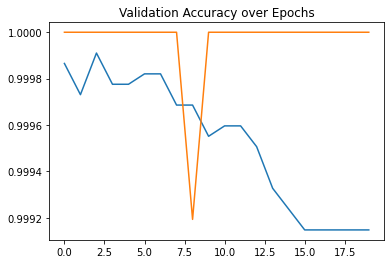

In [17]:
testValuesOfN(10)